## Example: kPCA and clustering for 2d and sequence data

Next, we'll illustrate how to run kPCA and kernel k-means clustering
using xGPR. We'll look at a simple 2d dataset first to build some intuitions,
then use some unaligned sequence data (sequences not part of an alignment
that are of many different lengths) to do some clustering. Note that to
run this demo, you'll need to download the github repo, since it includes
the test data (not included with the source distribution) and uses
the location of this notebook in the repo to find the test data.

In [57]:
import os
import numpy as np
import xGPR
import matplotlib.pyplot as plt
from xGPR import KernelxPCA, KernelFGen, build_online_dataset
from sklearn.datasets import make_circles
from sklearn.cluster import KMeans

if "test_data" not in os.getcwd():
    os.chdir(os.path.join("..", "..", "test_data"))

We'll start off with a simple classic -- the circles dataset. We know because we generated
it the data contains two clusters. But can we recover two clusters?

Text(0, 0.5, 'Arbitrary units')

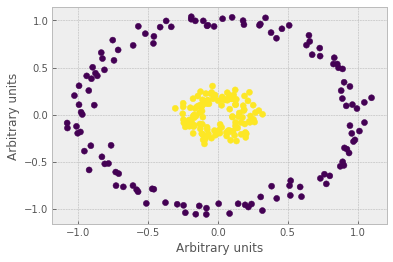

In [101]:
cx, cy = make_circles(n_samples=250, shuffle=True, noise=0.05, random_state=123, factor=0.2)

plt.style.use("bmh")
plt.scatter(cx[:,0], cx[:,1], c=cy)
plt.xlabel("Arbitrary units")
plt.ylabel("Arbitrary units")

We already know k-means which assumes spherical clusters will perform poorly here, but just for fun...

Text(0, 0.5, 'Arbitrary units')

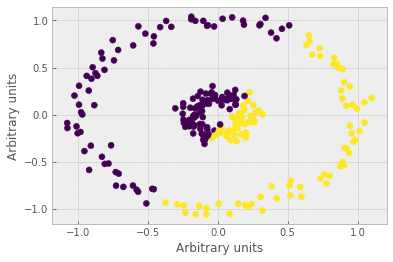

In [102]:
km = KMeans(n_clusters=2, random_state=123, n_init=5).fit(cx)

plt.style.use("bmh")
plt.scatter(cx[:,0], cx[:,1], c=km.labels_)
plt.xlabel("Arbitrary units")
plt.ylabel("Arbitrary units")

Very bad, as expected. We can do much better using kernel k-means, *but* as we'll see, the results
depend on our settings and *the hyperparameter that we use*. Notice that when constructing a dataset, xGPR
requires y-labels -- if we're using xGPR for clustering, we can just pass zeros or arbitrary
values when constructing this dataset. (This will be updated in a future version.)

Text(0, 0.5, 'Arbitrary units')

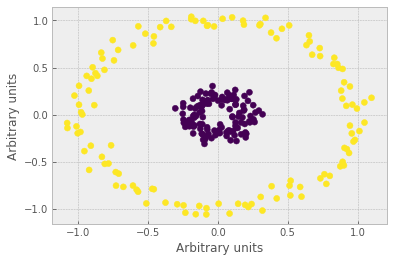

In [109]:
dataset = build_online_dataset(moon_x, np.zeros((moon_y.shape[0])), chunk_size=500)
kfgen = KernelFGen(num_rffs=512, dataset=dataset, kernel_choice="RBF",
                   random_seed=123, hyperparams=np.array([1]),
                  kernel_specific_params={"intercept":False})

features = kfgen.predict(cx)
km = KMeans(n_clusters=2, random_state=123, n_init=5).fit(features)

plt.style.use("bmh")
plt.scatter(cx[:,0], cx[:,1], c=km.labels_)
plt.xlabel("Arbitrary units")
plt.ylabel("Arbitrary units")

This looks nice, but...and here's the tricky part -- if we use a non-optimal hyperparameter we
can easily make this much worse. Let's see:

Text(0, 0.5, 'Arbitrary units')

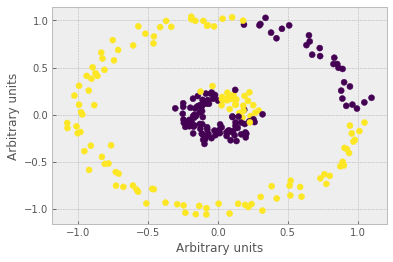

In [114]:
kfgen = KernelFGen(num_rffs=512, dataset=dataset, kernel_choice="RBF",
                   random_seed=123, hyperparams=np.array([-1.5]),
                  kernel_specific_params={"intercept":False})

features = kfgen.predict(moon_x)
km = KMeans(n_clusters=2, random_state=123, n_init=5).fit(features)

plt.style.use("bmh")
plt.scatter(cx[:,0], cx[:,1], c=km.labels_)
plt.xlabel("Arbitrary units")
plt.ylabel("Arbitrary units")

And now we're doing no better than K-means! The performance of the kernel k-means algorithm depends
on the choice of kernel and the choice of hyperparameter. This can be tricky. When fitting a
Gaussian process, we know which kernel and which hyperparameters we prefer -- the ones that
maximize the marginal likelihood or provide the best performance on a validation set. For clustering
and kPCA, there is no similar way to optimize the hyperparameter, which can make this challenging.

Let's look at a more interesting example -- a set of sequences.

There are 356 sequences


Text(0.5, 0, 'Sequence length')

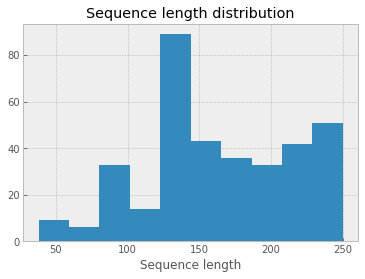

In [115]:
with open("cluster_seqs.txt", "r") as fhandle:
    raw_seqs = [l.strip() for l in fhandle]

print(f"There are {len(raw_seqs)} sequences")
    
_ = plt.hist([len(l) for l in raw_seqs])
plt.title("Sequence length distribution")
plt.xlabel("Sequence length")

These are very clearly not aligned. We can try to cluster and / or visualize them using the FHTConv1d
kernel in xGPR; this is equivalent to summing over (or averaging over, if we so choose) the pairwise
similarity of all k-mers of a preselected length in the sequences. First, we'll need to encode them.
We could zero-pad them to be the same length so that we can fit them all in one array then turn this
into an xGPR OnlineDataset, or we can group them by length, save each length batch in a numpy array file
on disk, then turn this list of files into an OfflineDataset.